In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
from dataset import HallucinationDataset
from torch.utils.data import DataLoader

train = HallucinationDataset("data/val/val.model-agnostic.json", "MT")
train_loader = DataLoader(train, batch_size=128)

In [38]:
import torch
from transformers import AutoTokenizer, AutoModel
from torch.nn.functional import cosine_similarity, cross_entropy

tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
model = AutoModel.from_pretrained("cointegrated/LaBSE-en-ru")

device = "cuda"
model.to(device)

ce = []
acc = []

def calculate_acc(preds, label, thr=0.85):
    return (label == (preds > thr).int()).float().mean()

def get_embeddings(output):
    return torch.nn.functional.normalize(output.pooler_output)

In [43]:
all_preds = []
all_labels = []

for batch in train_loader:
    hyp = tokenizer(batch["hyp"], padding=True, truncation=True, max_length=64, return_tensors='pt').to(device)
    src = tokenizer(batch["src"], padding=True, truncation=True, max_length=64, return_tensors='pt').to(device)
    
    with torch.no_grad():
        en_emb = get_embeddings(model(**hyp))
        ru_emb = get_embeddings(model(**src))

    label = list(batch["label"].numpy())
    preds = list(cosine_similarity(en_emb, ru_emb).cpu().detach().numpy())

    all_preds.extend(preds)
    all_labels.extend(label)

    # ce.append(cross_entropy(preds, label.float()))
    # acc.append(calculate_acc(preds, label))

In [13]:
ce, acc

([tensor(272.2440, device='cuda:0'), tensor(199.6543, device='cuda:0')],
 [tensor(0.7812, device='cuda:0'), tensor(0.7966, device='cuda:0')])

In [44]:
roc_auc_score(all_labels, all_preds)

0.8452131376659678

0.786096256684492


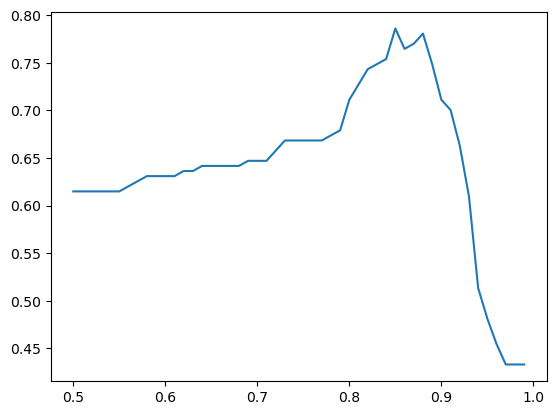

In [45]:
import numpy as np
from matplotlib import pyplot as plt

accuracy_lst = []

for threshold in np.arange(0.5, 1.0, 0.01):
    answers = [int(value) for value in np.array(all_preds) > threshold]
    accuracy_lst.append((np.array(all_labels) == np.array(answers)).mean())

print(max(accuracy_lst))

plt.plot(np.arange(0.5, 1.0, 0.01), accuracy_lst)

### Blaser-2.0

In [3]:
from pathlib import Path
from typing import List, Sequence, Union

import torch
from fairseq2.data import Collater, StringLike
from fairseq2.data.cstring import CString
from fairseq2.data.data_pipeline import read_sequence
from fairseq2.data.text import TextTokenizer, read_text
from fairseq2.generation import BeamSearchSeq2SeqGenerator, TextTranslator
from fairseq2.models.transformer import TransformerDecoderModel
from fairseq2.typing import Device

from sonar.inference_pipelines.utils import extract_sequence_batch
from sonar.models.encoder_model import SonarEncoderModel, SonarEncoderOutput
from sonar.models.sonar_text import (
    load_sonar_text_decoder_model,
    load_sonar_text_encoder_model,
    load_sonar_tokenizer,
)
from sonar.models.sonar_translation import SonarEncoderDecoderModel

CPU_DEVICE = torch.device("cpu")

class MyTextToEmbeddingModelPipeline(torch.nn.Module):
    model: SonarEncoderModel
    tokenizer: TextTokenizer

    def __init__(
        self,
        encoder: Union[str, SonarEncoderModel],
        tokenizer: Union[str, TextTokenizer],
        device: Device = CPU_DEVICE,
    ) -> None:
        """
        Args:
            encoder (Union[str, SonarEncoderModel]): either cart name or model object
            tokenizer (Union[str, TextTokenizer]): either cart name or tokenizer object
            device (device, optional): . Defaults to CPU_DEVICE.
        """
        super().__init__()
        if isinstance(encoder, str):
            encoder = load_sonar_text_encoder_model(
                encoder, device=device, progress=True
            )
        if isinstance(tokenizer, str):
            tokenizer = load_sonar_tokenizer(tokenizer, progress=False)

        self.tokenizer = tokenizer
        self.model = encoder.to(device).eval()
        self.device = device

    @torch.inference_mode()
    def predict(
        self, input: Union[Path, Sequence[str]], source_lang: str, batch_size: int = 5
    ) -> torch.Tensor:
        tokenizer_encoder = self.tokenizer.create_encoder(lang=source_lang)
        pipeline = (
            (
                read_text(input)
                if isinstance(input, (str, Path))
                else read_sequence(input)
            )
            .map(tokenizer_encoder)
            .bucket(batch_size)
            .map(Collater(self.tokenizer.vocab_info.pad_idx))
            .map(lambda x: extract_sequence_batch(x, self.device))
            .map(self.model)
            .and_return()
        )

        results: List[SonarEncoderOutput] = list(iter(pipeline))

        sentence_embeddings = torch.cat([x.sentence_embeddings for x in results], dim=0)
        return sentence_embeddings

In [10]:
# from sonar.inference_pipelines.text import TextToEmbeddingModelPipeline
from sonar.models.blaser.loader import load_blaser_model

blaser = load_blaser_model("blaser_2_0_qe").eval()
text_embedder = MyTextToEmbeddingModelPipeline(encoder="text_sonar_basic_encoder", tokenizer="text_sonar_basic_encoder", device=torch.device("cuda"))

device = "cuda"
blaser.to(device)

Using the cached checkpoint of blaser_2_0_qe. Set `force` to `True` to download again.
Using the cached checkpoint of text_sonar_basic_encoder. Set `force` to `True` to download again.


BlaserModel(
  (mlp): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=4096, out_features=3072, bias=True)
    (2): Tanh()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=3072, out_features=1536, bias=True)
    (5): Tanh()
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=1536, out_features=1, bias=True)
  )
)

In [12]:
src_embs = text_embedder.predict(["Кот сидит на ковре."], source_lang="rus_Cyrl").to(device)
mt_embs = text_embedder.predict(["The cat sat down on the carpet."], source_lang="eng_Latn").to(device)
print(blaser(src=src_embs, mt=mt_embs).item())

4.456824779510498


In [33]:
all_preds = []
all_labels = []

for batch in train_loader:

    with torch.no_grad():
        ru_emb = text_embedder.predict(batch["src"], source_lang="rus_Cyrl").to(device)
        en_emb = text_embedder.predict(batch["hyp"], source_lang="eng_Latn").to(device)

    label = batch["label"]
    preds = blaser(src=ru_emb, mt=en_emb).flatten().cpu() / 5

    all_preds.extend(list(preds.detach().numpy()))
    all_labels.extend(list(label.numpy()))

    ce.append(cross_entropy(preds, label.float()))
    acc.append(calculate_acc(preds, label))

In [36]:
roc_auc_score(all_labels, all_preds)

0.8525506638714185

In [22]:
ce

[tensor(272.8793, device='cuda:0', grad_fn=<DivBackward1>),
 tensor(199.4337, device='cuda:0', grad_fn=<DivBackward1>)]

In [23]:
acc

[tensor(0.7656, device='cuda:0'), tensor(0.7966, device='cuda:0')]

0.8021390374331551


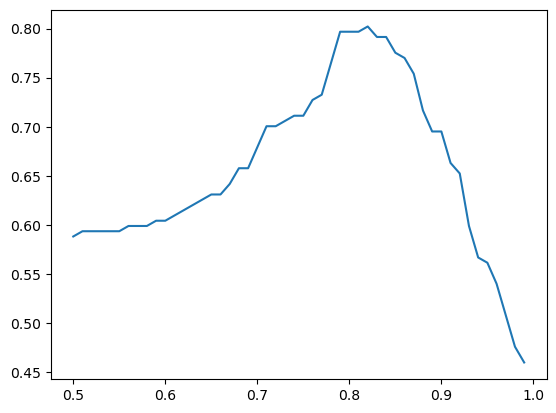

In [37]:
accuracy_lst = []

for threshold in np.arange(0.5, 1.0, 0.01):
    answers = [int(value) for value in np.array(all_preds) > threshold]
    accuracy_lst.append((np.array(all_labels) == np.array(answers)).mean())

print(max(accuracy_lst))

plt.plot(np.arange(0.5, 1.0, 0.01), accuracy_lst)